In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import sys
import pickle
from sklearn.decomposition import PCA
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PICKLE

In [0]:
fileObject_df1 = open('/content/drive/My Drive/Vision/test_1_8.pickle','rb')
X_test,y_test = pickle.load(fileObject_df1) 

fileObject_df2 = open('/content/drive/My Drive/Vision/train_1_4.pickle','rb')
X_train,y_train = pickle.load(fileObject_df2) 

# RESNET50

In [3]:
model_ResNet50 = tf.keras.applications.ResNet50(weights='imagenet')
model_ResNet50.summary()

W0821 01:30:47.103804 139842010093440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


102858752/102853048 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [0]:
model_firstL_Resnet = tf.keras.models.Model(inputs=model_ResNet50.input, outputs=model_ResNet50.get_layer('max_pooling2d').output)

In [5]:
X_train,X_test=np.array(X_train), np.array(X_test)
X_train_1=np.resize(X_train,(len(X_train),224,224,3))
X_test_1=np.resize(X_test, (len(X_test),224,224,3))

x_train = X_train_1.reshape([-1, 224, 224, 3])
x_test = X_test_1.reshape([-1, 224, 224, 3])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape,x_test.shape)

(4725, 224, 224, 3) (2196, 224, 224, 3)


In [0]:
X_train_,Y_train_=[],[]
for i in range(len(x_train)):
    imagen = x_train[i]    
    ima_trp1 = np.expand_dims(imagen, axis=0);
    features = model_firstL_Resnet.predict(ima_trp1)
    X_train_.append(np.reshape(features,newshape=(56*56*64)))
    
del x_train
X_train_=np.array(X_train_)

X_test_,Y_test_=[],[]
for i in range(len(x_test)):
    imagen = x_test[i]
    ima_trp1 = np.expand_dims(imagen, axis=0);
    features = model_firstL_Resnet.predict(ima_trp1)
    X_test_.append(np.reshape(features,newshape=(56*56*64)))
    Y_test_.append(y_test[i])
X_test_=np.array(X_test_)

# CLASIFICADORES

In [0]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

**NAIVE GAUSSIAN**

0.5136612021857924
[[761 660]
 [408 367]]


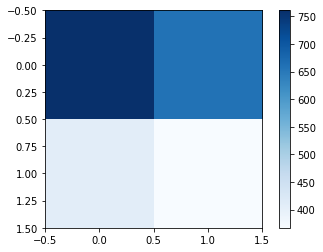

In [8]:
# With Naive Gaussian Classifier
accuracy_GN=[]
GN_est = GaussianNB()
GN_est.fit(X_train_, y_train)
GN_pr = GN_est.predict(X_test_)
print (GN_est.score(X_test_, y_test))
cm_test = confusion_matrix(y_test, GN_pr)
print(cm_test)
accuracy_GN.append(GN_est.score(X_test_, y_test))
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

**RANDOM FOREST**

10 0.6397996357012751
20 0.6438979963570127
30 0.6457194899817851
40 0.6443533697632058
50 0.6475409836065574
60 0.6466302367941712
70 0.6475409836065574
80 0.6466302367941712
90 0.6466302367941712
100 0.6470856102003643


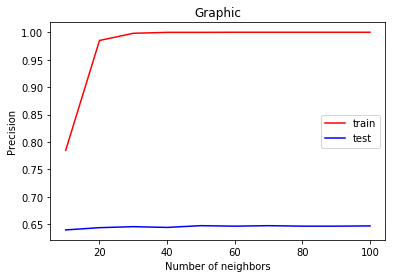

In [9]:
# With Random Forest
accuracy_RF,accuracy_RF_train=[],[]
x=[i for i in range(10,110,10)]
for i in range(10,110,10):
    RF_est = RandomForestClassifier(n_estimators=i,criterion='entropy', max_depth=i)
    RF_est.fit(X_train_, y_train)
    RF_pr = RF_est.predict(X_test_)
    accuracy_RF.append(RF_est.score(X_test_, y_test))
    accuracy_RF_train.append(RF_est.score(X_train_, y_train))
    print(i, RF_est.score(X_test_, y_test))
    
    #results
plt.plot(x, accuracy_RF_train, color='r', label='train')
plt.plot(x, accuracy_RF, color='b', label='test')
plt.title('Graphic')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Number of neighbors')
plt.show()

0.6420765027322405
[[1400   21]
 [ 765   10]]


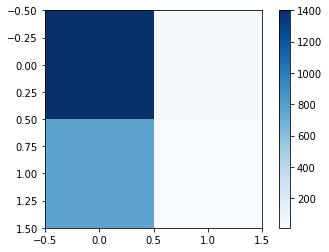

In [11]:
RF_est = RandomForestClassifier(n_estimators=10,criterion='entropy', max_depth=10)
RF_est.fit(X_train_, y_train)
RF_pr = RF_est.predict(X_test_)
print( RF_est.score(X_test_, y_test))
cm_test = confusion_matrix(y_test, RF_pr)
print(cm_test)
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

**THE BEST**

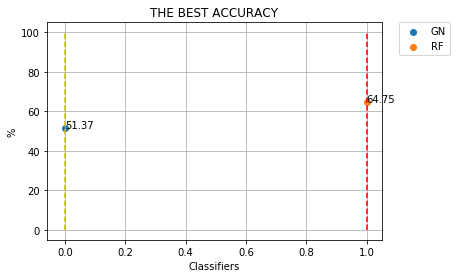

In [12]:
classi=['GN','RF']
acc=[np.round(np.max(accuracy_GN)*100,2),np.round(np.max(accuracy_RF)*100,2)]
x=[i for i in range(len(classi))]
for i, txt in enumerate(acc):
    plt.annotate(txt, (x[i], acc[i]))
    
plt.scatter(0, np.max(accuracy_GN)*100)
plt.scatter(1,  np.max(accuracy_RF)*100)
plt.title("THE BEST ACCURACY"), plt.ylabel("%"),plt.xlabel("Classifiers")
plt.vlines(0, 0, 100,colors="y", linestyles="dashed")
plt.vlines(1, 0, 100,colors="r", linestyles="dashed")
plt.grid()
plt.legend(("GN","RF"),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# VGG16

In [3]:
model_VGG16 = tf.keras.applications.VGG16(weights='imagenet')
model_VGG16.summary()

W0821 02:09:06.110658 139675455817600 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model_firstL_VGG16 = tf.keras.models.Model(inputs=model_VGG16.input, outputs=model_VGG16.get_layer('block3_pool').output)

In [5]:
X_train,X_test=np.array(X_train), np.array(X_test)
X_train_1=np.resize(X_train,(len(X_train),224,224,3))
X_test_1=np.resize(X_test, (len(X_test),224,224,3))

x_train = X_train_1.reshape([-1, 224, 224, 3])
x_test = X_test_1.reshape([-1, 224, 224, 3])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape,x_test.shape)

del X_train, X_test, X_train_1, X_test_1

(4725, 224, 224, 3) (2196, 224, 224, 3)


In [0]:
X_train_,Y_train_=[],[]
for i in range(len(x_train)):
    imagen = x_train[i]    
    ima_trp1 = np.expand_dims(imagen, axis=0);
    features = model_firstL_VGG16.predict(ima_trp1)
    X_train_.append(np.reshape(features,newshape=(28*28*256)))
    
del x_train
X_train_=np.array(X_train_)

X_test_,Y_test_=[],[]
for i in range(len(x_test)):
    imagen = x_test[i]
    ima_trp1 = np.expand_dims(imagen, axis=0);
    features = model_firstL_VGG16.predict(ima_trp1)
    X_test_.append(np.reshape(features,newshape=(28*28*256)))
    Y_test_.append(y_test[i])
X_test_=np.array(X_test_)
del x_test

# CLASIFICADORES

In [0]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

**GN**

0.4808743169398907
[[672 749]
 [391 384]]


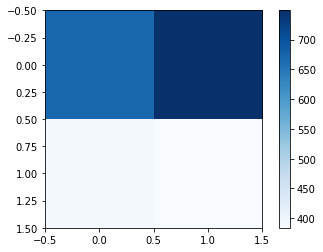

In [8]:
# With Naive Gaussian Classifier
accuracy_GN=[]
GN_est = GaussianNB()
GN_est.fit(X_train_, y_train)
GN_pr = GN_est.predict(X_test_)
print (GN_est.score(X_test_, y_test))
cm_test = confusion_matrix(y_test, GN_pr)
print(cm_test)
accuracy_GN.append(GN_est.score(X_test_, y_test))
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

**RF**

10 0.6429872495446266
20 0.6347905282331512
30 0.644808743169399
40 0.6434426229508197
50 0.6425318761384335
60 0.6479963570127505
70 0.6434426229508197
80 0.6457194899817851
90 0.6461748633879781
100 0.6466302367941712


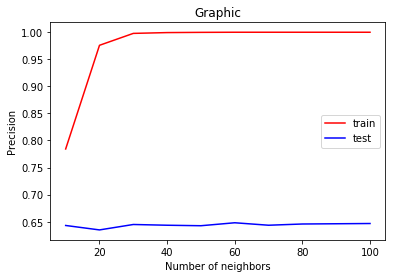

In [10]:
# With Random Forest
accuracy_RF,accuracy_RF_train=[],[]
x=[i for i in range(10,110,10)]
for i in range(10,110,10):
    RF_est = RandomForestClassifier(n_estimators=i,criterion='entropy', max_depth=i)
    RF_est.fit(X_train_, y_train)
    RF_pr = RF_est.predict(X_test_)
    accuracy_RF.append(RF_est.score(X_test_, y_test))
    accuracy_RF_train.append(RF_est.score(X_train_, y_train))
    print(i, RF_est.score(X_test_, y_test))
    
    #results
plt.plot(x, accuracy_RF_train, color='r', label='train')
plt.plot(x, accuracy_RF, color='b', label='test')
plt.title('Graphic')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Number of neighbors')
plt.show()

0.6407103825136612
[[1399   22]
 [ 767    8]]


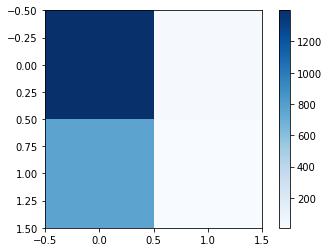

In [12]:
# With Naive Gaussian Classifier
accuracy_RF=[]
RF_est = RandomForestClassifier(n_estimators=10,criterion='entropy', max_depth=10)
RF_est.fit(X_train_, y_train)
RF_pr = RF_est.predict(X_test_)
print (RF_est.score(X_test_, y_test))
cm_test = confusion_matrix(y_test, RF_pr)
print(cm_test)
accuracy_RF.append(RF_est.score(X_test_, y_test))
plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

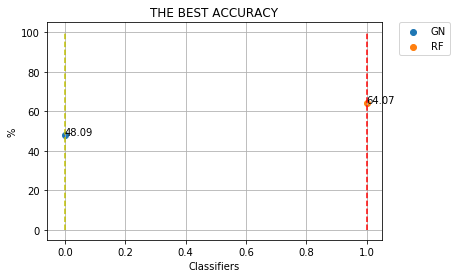

In [13]:
classi=['GN','RF']
acc=[np.round(np.max(accuracy_GN)*100,2),np.round(np.max(accuracy_RF)*100,2)]
x=[i for i in range(len(classi))]
for i, txt in enumerate(acc):
    plt.annotate(txt, (x[i], acc[i]))
    
plt.scatter(0, np.max(accuracy_GN)*100)
plt.scatter(1,  np.max(accuracy_RF)*100)
plt.title("THE BEST ACCURACY"), plt.ylabel("%"),plt.xlabel("Classifiers")
plt.vlines(0, 0, 100,colors="y", linestyles="dashed")
plt.vlines(1, 0, 100,colors="r", linestyles="dashed")
plt.grid()
plt.legend(("GN","RF"),bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()